In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/func_0'

In [3]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 83.77 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.20 sec

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 21.18 sec


In [4]:
dims = bbb.get_dims(brain)

In [5]:
# Step through each behavior time window for a single column
# No.
# Make a vector of 0s, with 1s where the voxel activity should be inserted
# The vector is the length of the behavior and desired temporal resolution
# Put a 1 where a voxel reading will exist
# Insert voxel activities
# repeat for next slice

In [6]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera

In [7]:
def interp_fictrac(fictrac, fps, resolution, expt_len):
    behavior = 'dRotLabY'
    sigma = 3
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[behavior]),sigma=sigma)
    fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(xnew)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [8]:
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len)

In [7]:
fictrac_interp.shape

(36000,)

In [9]:
def round_down_to_base(x, base=50):
    return [math.floor(i/base) for i in x]

In [10]:
indicies = round_down_to_base(timestamps[:,25])

In [35]:
timestamps_expaned = np.zeros((len(fictrac_interp)))

In [38]:
x=20
y=20
z=25
timestamps_expaned[indicies] = brain[x,y,z,:]

In [42]:
beta_len = 10

In [73]:
shift = -int(beta_len/2)
X = toeplitz(timestamps_expaned, np.zeros(beta_len))
X = np.roll(X,shift,axis=0)

In [74]:
X.shape

(36000, 10)

In [75]:
timestamps_expaned[:40]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.16402337,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  2.71324992,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.75468826,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  2.15304756,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

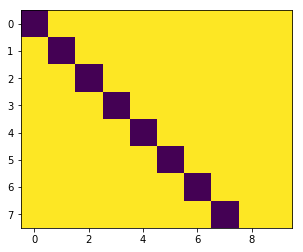

In [80]:
plt.imshow(X[:8,:]*100)

In [50]:
timestamps_expaned = np.zeros((len(fictrac_interp)))
timestamps_expaned[indicies] = brain[40,40,25,:]
X = toeplitz(timestamps_expaned, np.zeros(beta_len))
X = np.roll(X,shift,axis=0)

In [51]:
shift

-50

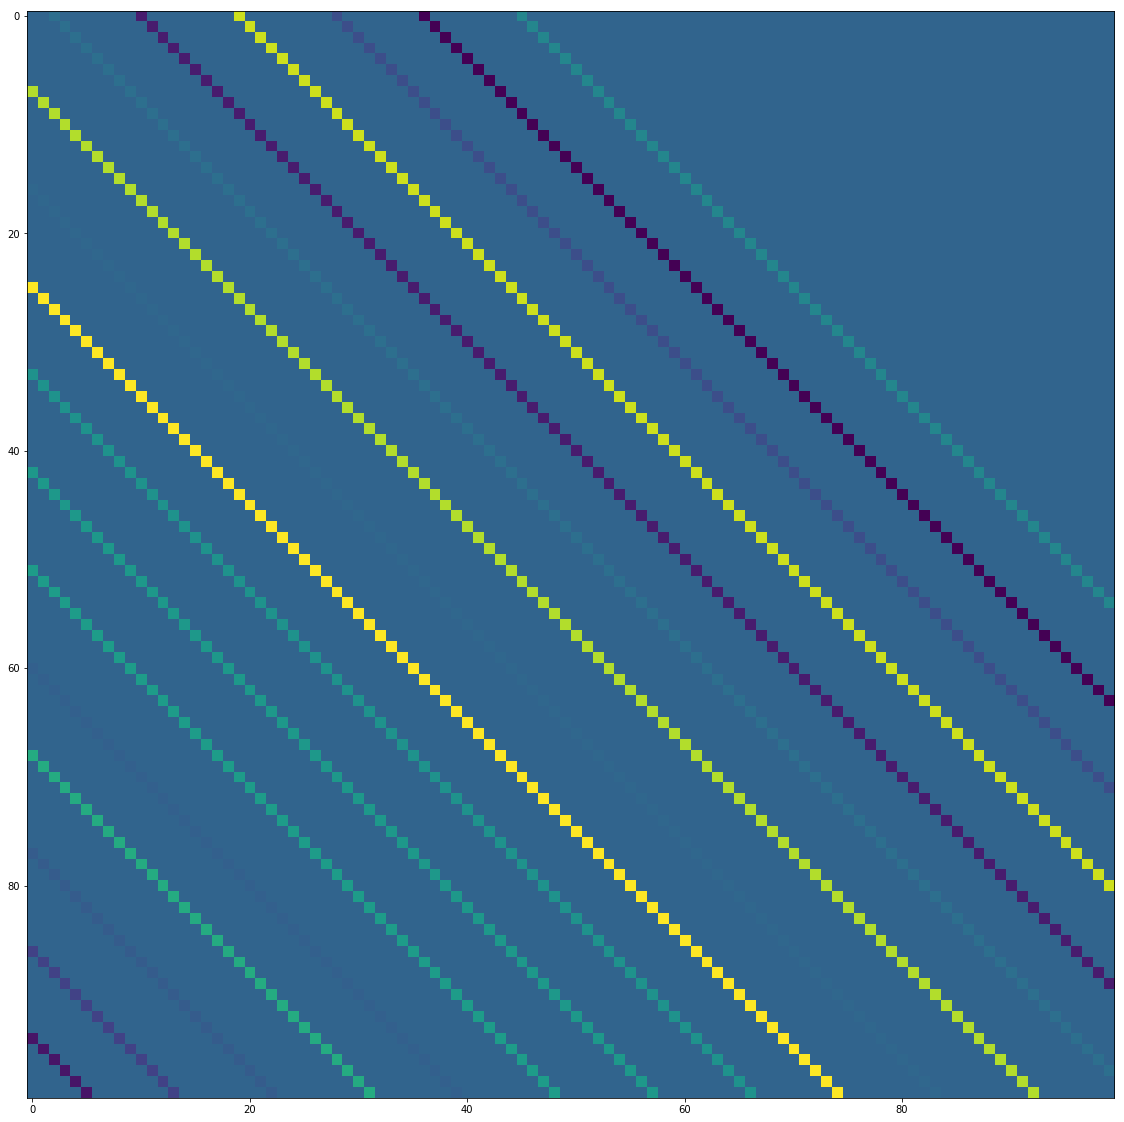

In [52]:
plt.figure(figsize=(20,20))
plt.imshow(X[:100,:])

In [39]:
X.shape

(36000, 100)

In [15]:
z=25
Y = fictrac_interp
beta_len = 100
shift = -int(beta_len/2)

betas = []
scores = []
for x in tqdm(range(dims['x'])):
    for y in range(dims['y']):
        timestamps_expaned = np.zeros((len(fictrac_interp)))
        timestamps_expaned[indicies] = brain[y,x,z,:]
        X = toeplitz(timestamps_expaned, np.zeros(beta_len))
        X = np.roll(X,shift,axis=0)
        model = LassoLarsIC(criterion='bic')
        model.fit(X, Y)
        betas.append(model.coef_)
        scores.append(model.score(X,Y))

100%|██████████| 92/92 [23:58<00:00, 12.06s/it]


In [88]:
scores2 = np.reshape(np.asarray(scores), (dims['x'], dims['y']))

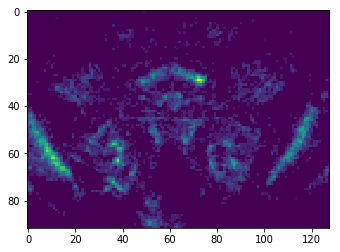

In [89]:
plt.imshow(scores2)

In [16]:
betas2 = np.reshape(np.asarray(betas), (dims['x'], dims['y'], -1))

In [17]:
betas2.shape

(92, 128, 100)

In [18]:
#file = os.path.join(directory, 'upsampling')
#os.mkdir(file)
file = os.path.join(directory, 'upsampling', 'betas_20190730_50ms_100bins.nii')
bbb.save_brain(file, betas2)


~~ save_brain ~~
Current memory usage: 20.77GB
save_brain done. Duration: 81.67 ms


In [20]:
betas3 = np.reshape(betas, (dims['x']*dims['y'], -1))

In [22]:
betas3.shape

(11776, 100)

In [34]:
bins

array([-2500, -2450, -2400, -2350, -2300, -2250, -2200, -2150, -2100,
       -2050, -2000, -1950, -1900, -1850, -1800, -1750, -1700, -1650,
       -1600, -1550, -1500, -1450, -1400, -1350, -1300, -1250, -1200,
       -1150, -1100, -1050, -1000,  -950,  -900,  -850,  -800,  -750,
        -700,  -650,  -600,  -550,  -500,  -450,  -400,  -350,  -300,
        -250,  -200,  -150,  -100,   -50,     0,    50,   100,   150,
         200,   250,   300,   350,   400,   450,   500,   550,   600,
         650,   700,   750,   800,   850,   900,   950,  1000,  1050,
        1100,  1150,  1200,  1250,  1300,  1350,  1400,  1450,  1500,
        1550,  1600,  1650,  1700,  1750,  1800,  1850,  1900,  1950,
        2000,  2050,  2100,  2150,  2200,  2250,  2300,  2350,  2400,
        2450])

In [30]:
bins = bbb.create_bins(50,2500,2450)

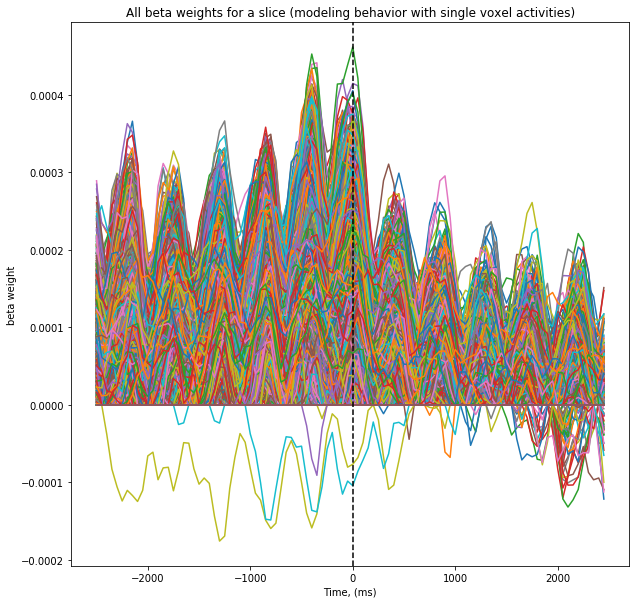

In [36]:
plt.figure(figsize=(10,10))
for i in range(dims['x']*dims['y']):
    plt.plot(bins, betas3[i,:])
plt.xlabel('Time, (ms)')
plt.ylabel('beta weight')
plt.title('All beta weights for a slice (modeling behavior with single voxel activities)')
plt.axvline(0,linestyle='--',color='k')

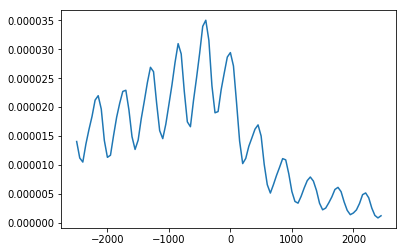

In [65]:
plt.plot(bins, np.mean(betas3,axis=0))

In [ ]:
def calc_event_triggered_delays(numpy_brain,
                                movement_times,
                                timestamps,
                                search_before=2000,
                                search_after=2000):
    
    useful_frames = []

    # For each behavior timepoint, find brain slices that occur near in time
    for i, movement_time in enumerate(movement_times):
        print('{} of {}. '.format(i+1, len(movement_times)), end='')
        # Define what time range to look across
        search_start = movement_time - search_before
        search_end = movement_time + search_after

        # Look at each z-slice
        for z in range(len(numpy_brain[0,0,:,0])):

            # Get times of the current slice
            slice_times = timestamps[:,z]

            # Find slices near current movement time
            for f, slice_time in enumerate(slice_times):
                if search_start <= slice_time <= search_end:

                    # Calculate delay
                    delay = slice_time - movement_time

                    # Save the index of the found slice, along with it's delay relative to movement
                    useful_frames.append({'slice': z, 'frame': f, 'delay': delay})
    return useful_frames

In [ ]:
def slice_moving_avg(voxel_slices, delays, start=-4000, stop=4000, step=100):
    
    means = []
    centers = []
    
    for window in range(int((stop - start) / step)):
        
        window_start = start + window * step
        window_end = window_start + step

        above = np.asarray([delay > window_start for delay in delays])
        below = np.asarray([delay < window_end for delay in delays])
        indicies = np.where(above & below)[0]
        
        values = [voxel_slices[index,:,:] for index in indicies]
        mean = np.mean(values, axis = 0)
        means.append(mean)
        
    return means

In [ ]:
def single_moving_avg(voxels, delays, start=-2000, stop=2000, step=100):
    means = []
    centers = []
    for window in range(int((stop - start) / step)):
        window_start = start + window * step
        window_end = window_start + step
        center = window_start + (step / 2)
        centers.append(center)
        above = np.asarray([delay > window_start for delay in delays])
        below = np.asarray([delay < window_end for delay in delays])
        indicies = np.where(above & below)[0]
        mean = np.mean([voxels[index] for index in indicies])
        means.append(mean)
    return means, centers